In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

%matplotlib inline

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.preprocessing import StandardScaler
from pylab import rcParams
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers



Using TensorFlow backend.


In [5]:
# Load the clean dataset
UNSW_NB15_dataset = pd.read_csv('UNSW_NB15_dataset.csv',index_col=0)
UNSW_NB15_dataset.head()



/Applications/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,sport,dsport,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,Sload,...,state_INT,state_MAS,state_PAR,state_REQ,state_RST,state_TST,state_TXD,state_URH,state_URN,state_no
0,1390.0,53.0,0.001055,132,164,31,29,0,0,500473.93750,...,0,0,0,0,0,0,0,0,0,0
1,33661.0,1024.0,0.036133,528,304,31,29,0,0,87676.08594,...,0,0,0,0,0,0,0,0,0,0
2,1464.0,53.0,0.001119,146,178,31,29,0,0,521894.53130,...,0,0,0,0,0,0,0,0,0,0
3,3593.0,53.0,0.001209,132,164,31,29,0,0,436724.56250,...,0,0,0,0,0,0,0,0,0,0
4,49664.0,53.0,0.001169,146,178,31,29,0,0,499572.25000,...,0,0,0,0,0,0,0,0,0,0


In [6]:

from sklearn.model_selection import train_test_split

# Train, validation, test : 98%, 1%, 1% of dataset
X_train, X = train_test_split(UNSW_NB15_dataset, test_size = 0.02, random_state = 101)

# We need to train our model on the normal observations only.
X_train = X_train[X_train.Label == 0] # just normal observations
X_train = X_train.drop(['Label'], axis=1) # drop the Label column

y = X['Label'] # save the Label column for the validation and test sets
X = X.drop(['Label'], axis=1) # drop the Label column

# Create the validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X, y, test_size = 0.5, random_state = 101)

#transform to ndarray
X_train = X_train.values 
X_val = X_val.values
X_test = X_test.values


In [7]:
print ('train size:', X_train.shape)
print ('validation size:', X_val.shape)
print ('test size:', X_test.shape)

train size: (2174059, 277)
validation size: (25397, 277)
test size: (25398, 277)


In [8]:
from sklearn.preprocessing import StandardScaler

st_sc = StandardScaler()
X_train = st_sc.fit_transform(X_train)
X_val = st_sc.transform(X_val)
X_test = st_sc.transform(X_test)


In [9]:
input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim, ))

encoded = Dense(128, activation='relu')(input_layer)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(input_dim, activation='relu')(decoded)

autoencoder = Model(input_layer, decoded)

In [10]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 277)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               35584     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_5 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_6 (Dense)              (None, 277)               35733     
Total para

In [15]:
import datetime

autoencoder.compile(optimizer='adam',
                    loss='mse') 

checkpointer = ModelCheckpoint(filepath="anomaly_autoencoders_model.h5",
                               verbose=0,
                               save_best_only=True)

tensorboard = TensorBoard(write_graph=True,
                          write_images=True)

start_time = datetime.datetime.now()

history = autoencoder.fit(X_train, X_train,
                    epochs=100,
                    batch_size=512,
                    shuffle=True,
                    validation_data=(X_val, X_val),
                    verbose=0,
                    callbacks=[checkpointer, tensorboard])

end_time = datetime.datetime.now()

print('Time taken to run the model: {} Sec.'.format((end_time - start_time).total_seconds()))

In [3]:
autoencoder = load_model('anomaly_autoencoders_model.h5')

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = np.arange(1, 100 + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation mse')
plt.xlabel('Epochs')
plt.ylabel('mse')
plt.legend()
plt.show()



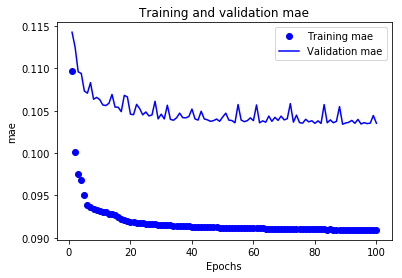

In [24]:
mae_values = history_dict['mean_absolute_error'] 
val_mae_values = history_dict['val_mean_absolute_error']
plt.plot(epochs, mae_values, 'bo', label='Training mae')
plt.plot(epochs, val_mae_values, 'b', label='Validation mae')
plt.title('Training and validation mae')
plt.xlabel('Epochs')
plt.ylabel('mae')
plt.legend()
plt.show()


In [11]:
predictions = autoencoder.predict(X_test)


In [12]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
rmse = pow(mse,0.5)
error_df = pd.DataFrame({'reconstruction_error': rmse,
                        'true_class': y_test})
error_df.describe()

,reconstruction_error,true_class
count,25398.000000,25398.000000
mean,0.694080,0.127175
std,0.865191,0.333176
min,0.314611,0.000000
25%,0.366240,0.000000
50%,0.396312,0.000000
75%,0.599171,0.000000
max,61.148930,1.000000


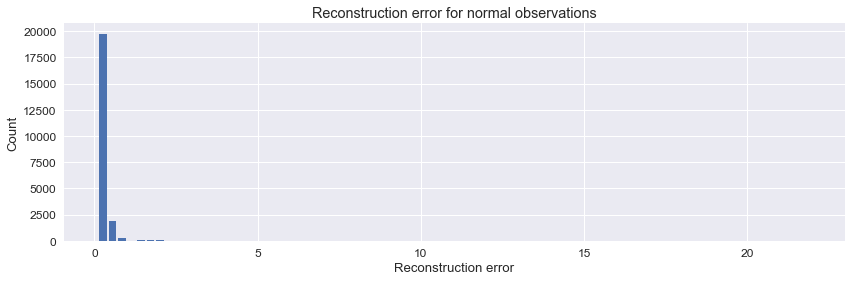

In [22]:
sns.set(font_scale=1.2)
normal_data = error_df[(error_df['true_class']== 0)].reconstruction_error
normal_data.hist(bins=75, rwidth=.8, figsize=(14,4))
plt.title('Reconstruction error for normal observations')
plt.xlabel('Reconstruction error')
plt.ylabel('Count')
plt.show()



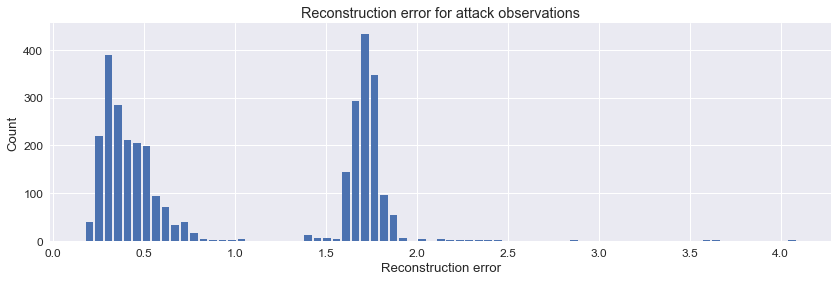

In [23]:
sns.set(font_scale=1.2)
attack_data = error_df[(error_df['true_class']== 1)].reconstruction_error
attack_data.hist(bins=75, rwidth=.8, figsize=(14,4))
plt.title('Reconstruction error for attack observations')
plt.xlabel('Reconstruction error')
plt.ylabel('Count')
plt.show()
         

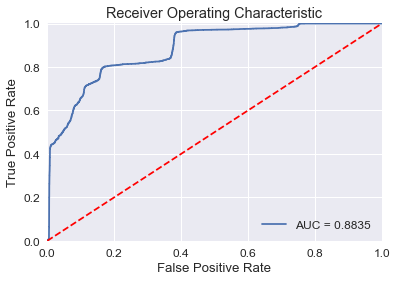

In [24]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



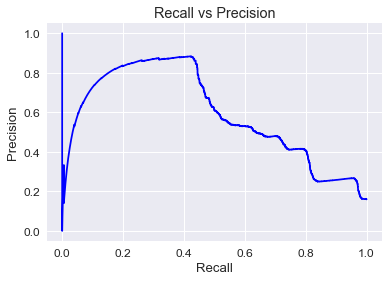

In [25]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()


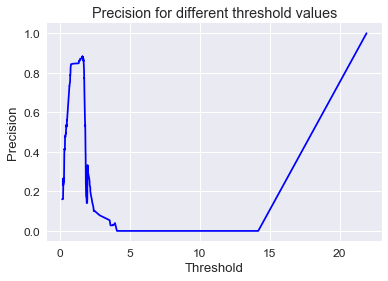

In [26]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()


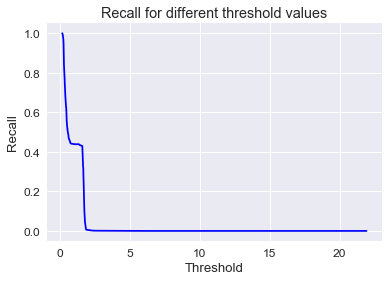

In [27]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.show()


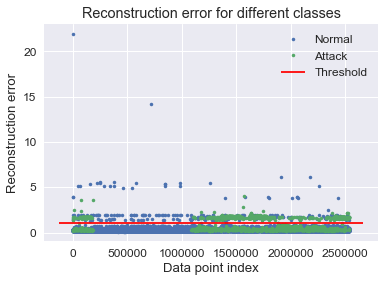

In [28]:
threshold = 1.
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Attack" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()


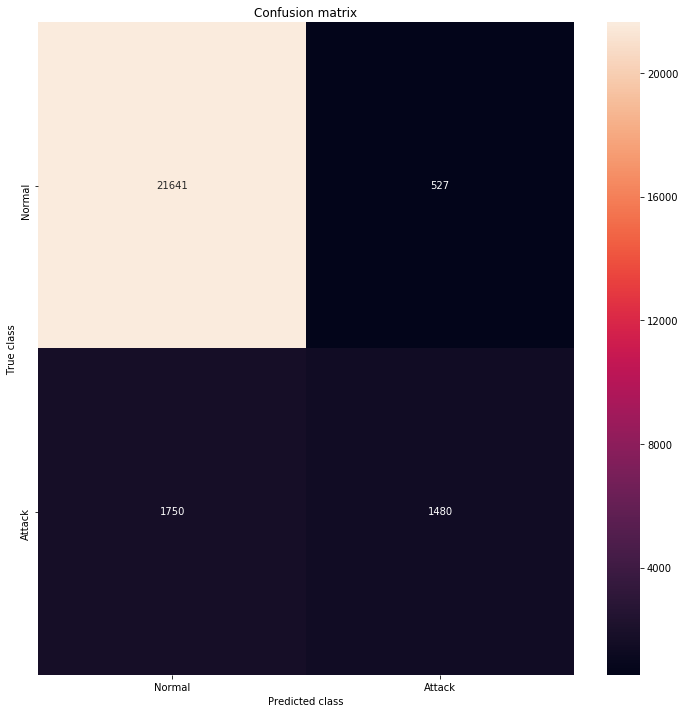

In [15]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=["Normal", "Attack"], 
            yticklabels=["Normal", "Attack"], annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()



In [ ]:
# List of outliers
threshold = 0.9
outliers_index = error_df.index[error_df.reconstruction_error > 0.9].tolist()



In [ ]:
# Let's compute reconstruction error per feature

data_n = pd.DataFrame(X_test, index= y_test.index, columns= X_test.columns)
def compute_error_per_feature(index):
    
    initial_input = np.array(data_n.loc[index,:]).reshape(1, input_dim)
    reconstrcuted_input = autoencoder.predict(initial_input)
    
    return abs(np.array(initial_input  - reconstrcuted_input)[0])



In [ ]:
RE_per_feature = {}
for idx in outliers:
    RE_per_feature[idx] = compute_error_per_feature(idx)
    
RE_per_feature = pd.DataFrame(RE_per_feature, index= X_test.columns).T


In [ ]:
RE_per_feature.head()

In [ ]:
# Create bar plot of "RE_per_feature"

import random

sns.set(font_scale=1.2)
# Select 10 random index from outliers_index and
# create the bar plot of reconstruction error for features
for idx in random.sample(outliers_index, 10):
    
    x = RE_per_feature.columns.tolist()
    y = RE_per_feature.loc[idx]
    index = np.arange(len(x))
    plt.bar(x, y)
    plt.xlabel('Features', fontsize=5)
    plt.ylabel('Reconstruction error', fontsize=5)
    plt.xticks(index, x, rotation=30, fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('Reconstruction error in each feature for data point with index %s'%idx)
    plt.show()
 


